This notebook performs the following validations on the forecasting models:
1. Calibration
2. Comparison Harvey vs logistic
3. Comparison independant vs joint model

# Import data and implement modeling

In [1]:
import pandas as pd
import arviz as az
import pymc as pm
import numpy as np
from typing import Literal

In [2]:
dataset = (
    pd.read_csv("benchmark_data_processed/all_normalized_updated_benchmarks.csv")
    .astype(
        {
            "benchmark": "string",
            "release_date": "datetime64[ns]",
            "score": "float64",
            "lower_bound": "float64",
        }
    )
    .dropna(subset=["benchmark", "release_date", "score", "lower_bound"])
)

In [ ]:
def get_frontier(df: pd.DataFrame, top_n: int = 1) -> pd.DataFrame:
    """Filter the dataset to include only the top_n frontier scores for each benchmark.

    Args:
        df: A dataset with columns "benchmark", "release_date", and "score".
        top_n: Number of top scores to consider when filtering the dataset.
    Returns:
        A filtered dataset containing only the top_n frontier scores for each benchmark.
    """
    return (
        df.sort_values(["benchmark", "release_date"])
        .assign(
            expanding_rank=lambda df: df.groupby("benchmark")["score"]
            .expanding()
            .rank(ascending=False, method="max")
            .reset_index(level=0, drop=True)
        )
        .loc[lambda df: df["expanding_rank"] <= top_n]
        .drop(columns=["expanding_rank"])
        .reset_index(drop=True)
    )

def fit_model(
    dataset: pd.DataFrame,
    sigmoid_kind: Literal["logistic", "harvey"] = "logistic",
    top_n: int = 3,
    n_samples: int = 2000,
    n_tune: int = 1000,
    progressbar: bool = True,
) -> tuple[az.InferenceData, pm.Model]:
    """Fit a Bayesian model to the dataset using the specified sigmoid function.

    If the dataset contains more than one benchmark, a joint model with shared hyperparameters is fitted.

    This allows benchmarks to inform each other through common priors on:
    - L_mu, L_sigma: (upper) asymptote distribution parameters
    - k_mu, k_sigma: growth rate distribution parameters
    - xi_base_mu, xi_base_sigma: noise level distribution parameters
    - s_mu, s_sigma: skewness distribution parameters

    Args:
        dataset: A dataset containing benchmark data. It must contain the columns 'score', 'release_date', 'benchmark' and 'lower_bound' of types float, datetime, string, and float respectively.
        sigmoid_kind: Type of sigmoid function to model the latent mean performance growth ('logistic' or 'harvey').
        top_n: Number of top scores to consider when fitting the model. If top_n=1, only the frontier scores are used.
        n_samples: Number of MCMC samples to draw from the posterior distribution.
        n_tune: Number of tuning steps for the MCMC sampler.
        progressbar: Whether to display a progress bar during sampling.
        
    Returns:
        A tuple containing an arviz InferenceData object with the posterior samples and the pymc Model object.
    """
    # Check validity of the dataset
    required_columns_and_types = {
        "score": pd.api.types.is_float_dtype,
        "release_date": pd.api.types.is_datetime64_any_dtype,
        "benchmark": pd.api.types.is_string_dtype,
        "lower_bound": pd.api.types.is_float_dtype,
    }
    for column, check_type in required_columns_and_types.items():
        if column not in dataset.columns:
            raise ValueError(f"Dataset must contain the column '{column}'.")
        if not check_type(dataset[column]):
            raise TypeError(f"Column '{column}' must be of type {check_type.__name__}.")
        if dataset[column].isnull().any():
            raise ValueError(f"Column '{column}' must not contain null values.")

    # Filter in the top_n frontier scores
    dataset = get_frontier(dataset, top_n=top_n)

    # Prepare necessary columns for modeling
    dataset = dataset.assign(
        days=lambda df: (
            df["release_date"]
            - df.groupby("benchmark")["release_date"].transform("min")
        ).dt.days
    ).assign(
        days_mid=lambda df: (df.groupby("benchmark")["days"].transform("max") / 2.0)
    )

    # Encode benchmark names as indices for pymc coords
    # Use `benchmark_idx` to index the dataset within the model
    benchmark_idx, benchmark_names = pd.factorize(dataset["benchmark"], sort=True)
    dataset["benchmark_idx"] = benchmark_idx
    coords = {
        "benchmark": benchmark_names,
        "obs": np.arange(len(dataset)),
    }

    with pm.Model(coords=coords) as model:
        # Upper asymptote
        L_min = 0.75
        L_max = 1.0
        L_range = L_max - L_min
        L_raw_mu = pm.Beta(
            "L_raw_mu", mu=(0.96 - L_min) / L_range, sigma=0.02 / L_range
        )
        L_raw_sigma = pm.HalfNormal("L_raw_sigma", sigma=0.02 / L_range)
        L_raw = pm.Beta("L_raw", mu=L_raw_mu, sigma=L_raw_sigma, dims="benchmark")
        L = pm.Deterministic("L", L_min + L_range * L_raw, dims="benchmark")

        # Lower bound
        l = pm.Data(
            "l",
            dataset["lower_bound"].groupby(dataset["benchmark_idx"]).first().values,
            dims="benchmark",
        )

        # Inflection point
        days_mid = dataset["days_mid"].groupby(dataset["benchmark_idx"]).first().values
        tau = pm.Gumbel("tau", mu=days_mid, beta=365 * 2, dims="benchmark")

        # Timestamps
        t_obs = pm.Data("t_obs", dataset["days"].values, dims="obs")
        idx_obs = pm.Data("idx_obs", dataset["benchmark_idx"].values, dims="obs")

        # Growth rate
        k_mu = pm.Gamma("k_mu", mu=0.005, sigma=0.002)
        k_sigma = pm.HalfNormal("k_sigma", sigma=0.005)
        k = pm.Gamma("k", mu=k_mu, sigma=k_sigma, dims="benchmark")

        # Mean latent performance
        logits = k[idx_obs] * (t_obs - tau[idx_obs])
        if sigmoid_kind == "logistic":
            sigmoid = pm.math.sigmoid(logits)
        elif sigmoid_kind == "harvey":
            alpha_raw_mu = pm.Gamma("alpha_raw_mu", mu=1.5, sigma=0.5)
            alpha_raw_sigma = pm.HalfNormal("alpha_raw_sigma", sigma=0.5)
            alpha_raw = pm.Gamma(
                "alpha_raw", mu=alpha_raw_mu, sigma=alpha_raw_sigma, dims="benchmark"
            )
            alpha = pm.Deterministic("alpha", alpha_raw + 1.0, dims="benchmark")
            base = pm.math.maximum(
                1 - (1 - alpha[idx_obs]) * pm.math.exp(-logits), 1e-10
            )
            sigmoid = pm.math.exp(1 / (1 - alpha[idx_obs]) * pm.math.log(base))
        else:
            raise ValueError(f"Unsupported sigmoid type: {sigmoid_kind}")
        mu = l[idx_obs] + (L[idx_obs] - l[idx_obs]) * sigmoid

        # Noise
        xi_base_mu = pm.Gamma("xi_base_mu", mu=0.05 + top_n / 50, sigma=0.02)
        xi_base_sigma = pm.HalfNormal("xi_base_sigma", sigma=0.05)
        xi_base = pm.Gamma(
            "xi_base", mu=xi_base_mu, sigma=xi_base_sigma, dims="benchmark"
        )
        variance_shape = pm.math.sqrt((mu - l[idx_obs]) * (L[idx_obs] - mu))
        max_variance = (L[idx_obs] - l[idx_obs]) / 2.0
        noise_factor = variance_shape / pm.math.maximum(max_variance, 1e-10)
        xi_0 = 0.01
        xi = xi_0 + xi_base[idx_obs] * noise_factor

        # Skewness
        s_mu = pm.Normal("s_mu", mu=-2 - top_n / 2, sigma=0.5)
        s_sigma = pm.HalfNormal("s_sigma", sigma=1)
        s = pm.TruncatedNormal("s", mu=s_mu, sigma=s_sigma, upper=0, dims="benchmark")

        # Observations
        y = pm.SkewNormal(
            "y",
            mu=mu,
            sigma=xi,
            alpha=s[idx_obs],
            observed=dataset["score"].values,
            dims="obs",
        )

        # Sample from the posterior
        idata = pm.sample(
            n_samples,
            tune=n_tune,
            return_inferencedata=True,
            random_seed=42,
            target_accept=0.9,
            init="adapt_diag",
            progressbar=progressbar,
        )

    return idata, model


# Validation

## Test

In [12]:
idata, _ = fit_model(dataset, sigmoid_kind="logistic", top_n=3)

Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [L_raw_mu, L_raw_sigma, L_raw, tau, k_mu, k_sigma, k, xi_base_mu, xi_base_sigma, xi_base, s_mu, s_sigma, s]


Output()

ValueError: Not enough samples to build a trace.

array([[<Axes: title={'center': 'L'}>, <Axes: title={'center': 'L'}>],
       [<Axes: title={'center': 'k'}>, <Axes: title={'center': 'k'}>],
       [<Axes: title={'center': 'xi_base'}>,
        <Axes: title={'center': 'xi_base'}>],
       [<Axes: title={'center': 's'}>, <Axes: title={'center': 's'}>]],
      dtype=object)

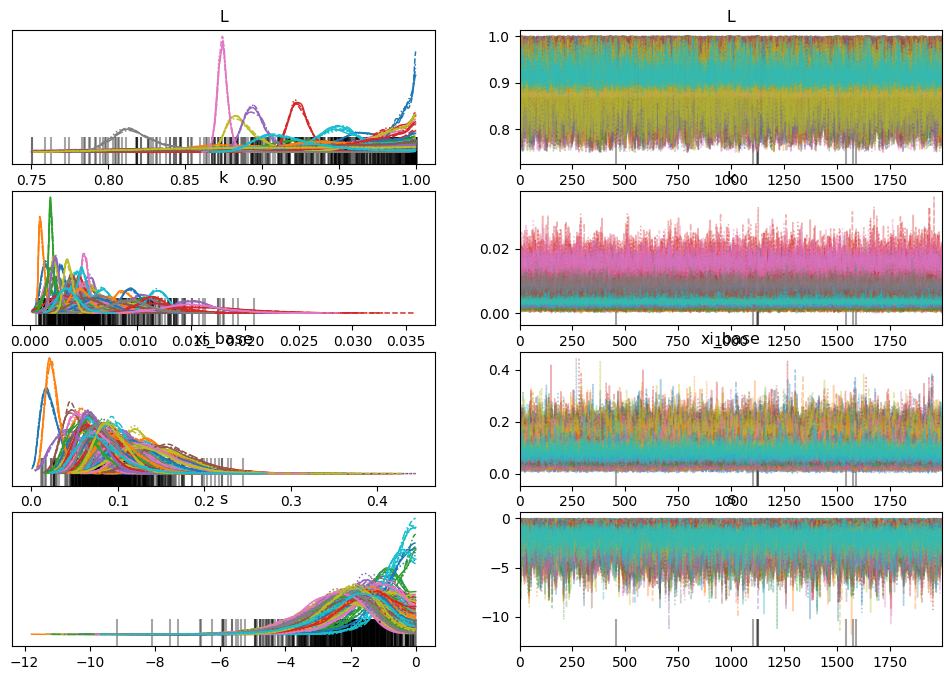

In [ ]:
az.plot_trace(idata, var_names=["L", "k", "xi_base", "s"])

## Calibration

In [ ]:
cutoff_date = pd.to_datetime("2024-01-01")
frontier_dataset = get_frontier(dataset, top_n=3)
train_data = frontier_dataset[frontier_dataset["release_date"] < cutoff_date]
test_data = (
    frontier_dataset
    [frontier_dataset["release_date"] >= cutoff_date]
    [frontier_dataset["benchmark"].isin(train_data["benchmark"].unique())]
)
train_idata, test_model = fit_model(
    train_data, sigmoid_kind="harvey", top_n=3, progressbar=True
)
with test_model:
    pm.set_data(
        {
            "t_obs": test_data["days"].values,
            "idx_obs": test_data["benchmark_idx"].values,
        }
    )
    test_idata = pm.sample_posterior_predictive(
        train_idata, var_names=["y"], random_seed=42, progressbar=True
    )

y_test = 


/var/folders/wc/cfb8c70d55l7nnd2jy67g3ww0000gp/T/ipykernel_14343/1336118442.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  frontier_dataset
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [L_raw_mu, L_raw_sigma, L_raw, tau, k_mu, k_sigma, k, alpha_raw_mu, alpha_raw_sigma, alpha_raw, xi_base_mu, xi_base_sigma, xi_base, s_mu, s_sigma, s]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 47 seconds.
There were 129 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>],
       [<Axes: title={'center': 's_mu'}>,
        <Axes: title={'center': 's_mu'}>],
       [<Axes: title={'center': 'L_raw_mu'}>,
        <Axes: title={'center': 'L_raw_mu'}>],
       [<Axes: title={'center': 'L_raw_sigma'}>,
        <Axes: title={'center': 'L_raw_sigma'}>],
       [<Axes: title={'center': 'L_raw'}>,
        <Axes: title={'center': 'L_raw'}>],
       [<Axes: title={'center': 'k_mu'}>,
        <Axes: title={'center': 'k_mu'}>],
       [<Axes: title={'center': 'k_sigma'}>,
        <Axes: title={'center': 'k_sigma'}>],
       [<Axes: title={'center': 'k'}>, <Axes: title={'center': 'k'}>],
       [<Axes: title={'center': 'alpha_raw_mu'}>,
        <Axes: title={'center': 'alpha_raw_mu'}>],
       [<Axes: title={'center': 'alpha_raw_sigma'}>,
        <Axes: title={'center': 'alpha_raw_sigma'}>],
       [<Axes: title={'center': 'alpha_raw'}>,
        <Axes: title={'center': 'alpha_raw'}>],
       [<Ax

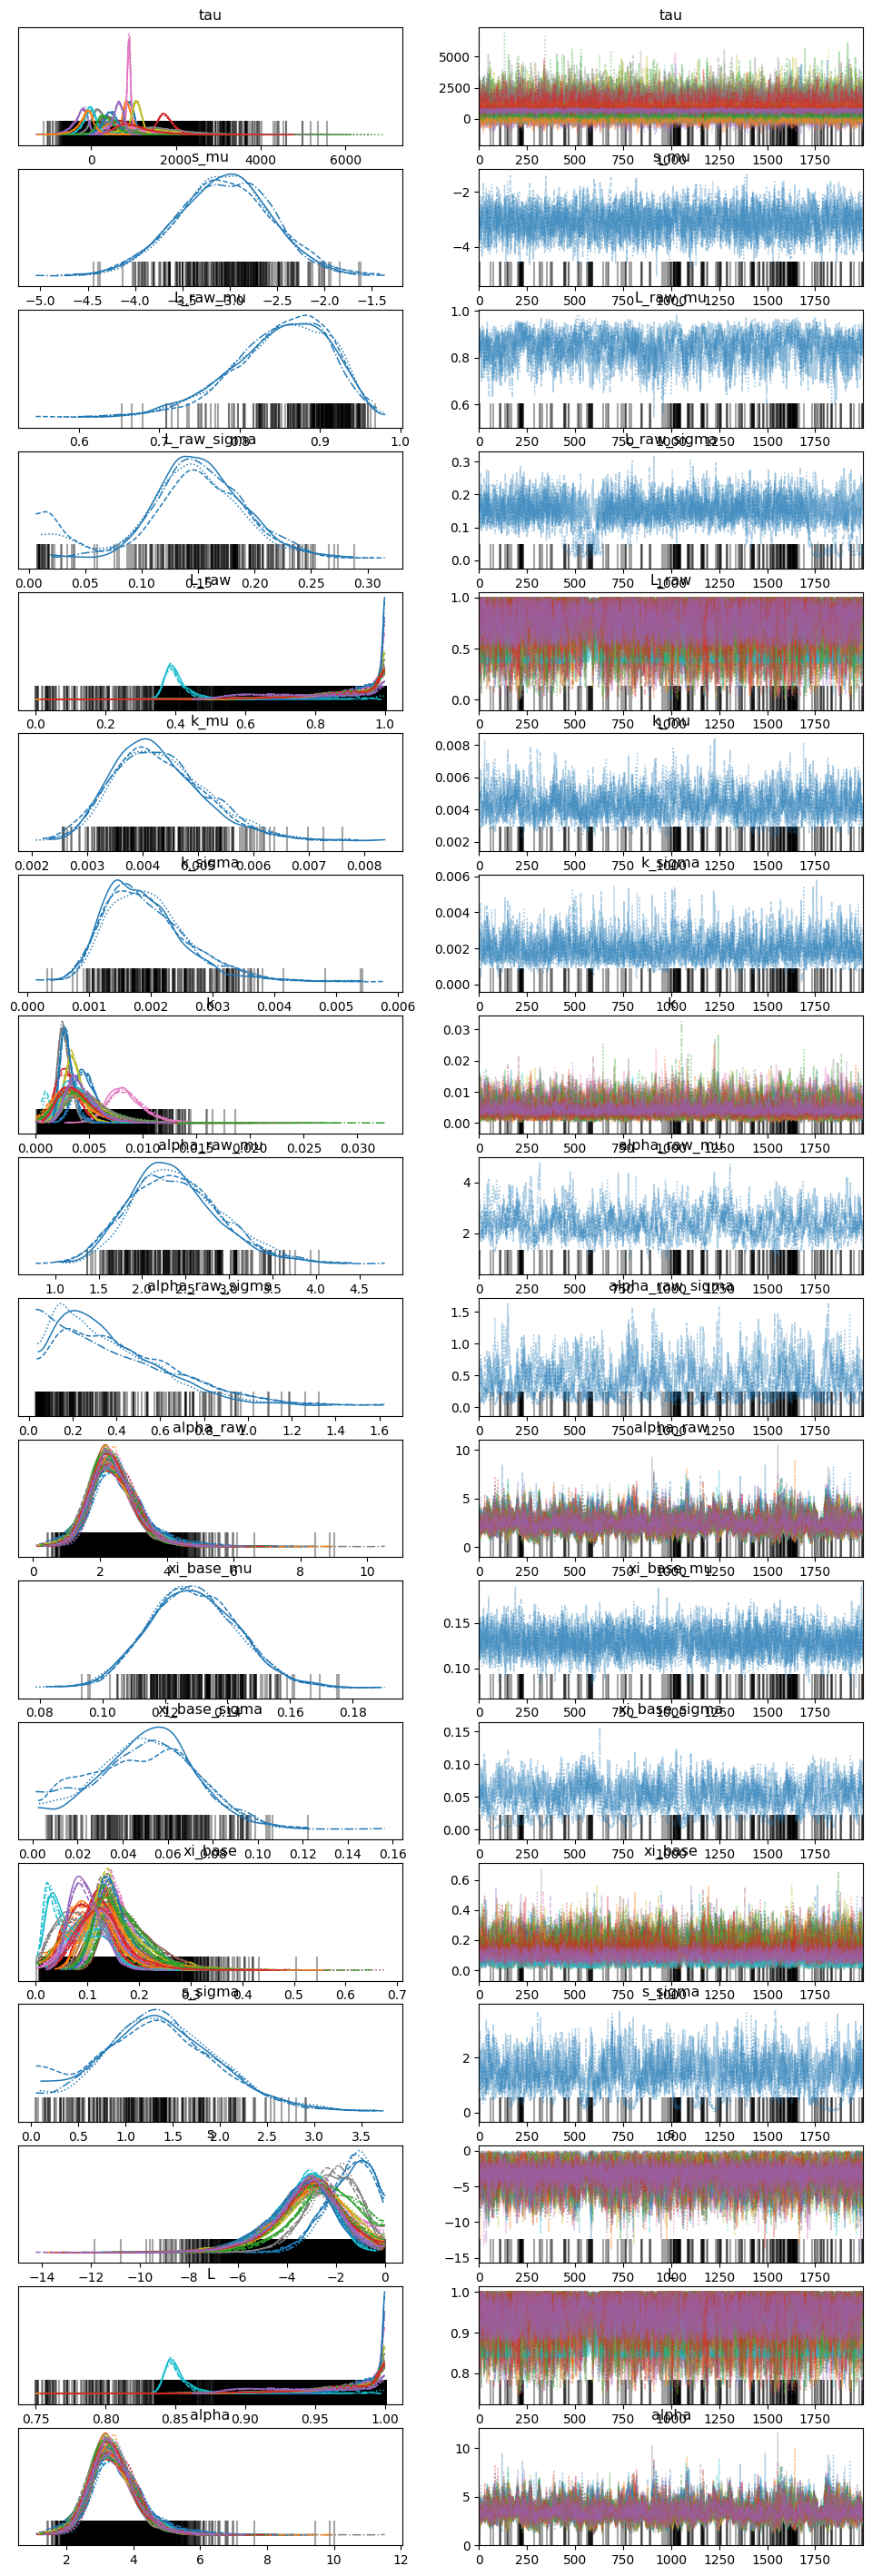

In [8]:
az.plot_trace(train_idata)